# Decision Tree Regressor Model

Our second model is the DecisionTreeRegressor. A Decision Tree Regressor is used for predicting continuous values. It works by recursively partitioning the data into subsets based on the values of input features, ultimately providing a tree-like structure of decisions. 

#### How it Works
First, you must split the data. The algorithm starts at the root node and selects the feature that best splits the data into subsets. The "best" split is determined by reducing the variance of the target variable within each subset. Next is recursive partitioning. This process is repeated for each subset, creating child nodes. This recursive partitioning continues until a stopping criterion is met, such as reaching a maximum depth or having a minimum number of samples in a node. The final nodes, called leaf nodes, contain the predicted continuous value. This value is often the mean or median of the target variable within that leaf.

#### Key Features
Interpretability:
- Decision trees are easy to interpret and visualize. The resulting tree structure can be understood and analyzed, making it a valuable tool for decision-making.

Non-linear Relationships:
- Decision trees can capture non-linear relationships between features and the target variable. They are capable of fitting complex patterns in the data.

Robust to Outliers:
- Decision trees are less sensitive to outliers compared to some other regression models. They partition the data based on relative ordering rather than absolute values.

Import dependencies for data manipulation and visualization

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Read in data from pkl file

In [28]:
ava = pd.read_pickle('../../data/ava_st1_ns4_56.pkl')
ava.head


<bound method NDFrame.head of        apcp_sf1_1  apcp_sf2_1 apcp_sf3_1  apcp_sf4_1  apcp_sf5_1  dlwrf_s1_1  \
V1       0.000000         0.0          1    0.000000    0.000000  256.492673   
V2       0.000000         0.0          1    0.017273    0.139091  257.998596   
V3       0.000000         0.0          1    0.000000    0.000000  219.280002   
V4       0.004545         0.0          1    0.000000    0.000000  267.863045   
V5       0.000000         0.0          1    0.000000    0.000000  238.162747   
...           ...         ...        ...         ...         ...         ...   
V4376    0.010909         0.0          1    0.000000    0.000000  278.168651   
V4377    0.000000         0.0          1    0.000000    0.000000  251.551092   
V4378    0.000000         0.0          1    0.000000    0.000000  269.446164   
V4379    0.000000         0.0          1    0.000000    0.000000  268.862049   
V4380    0.000000         0.0          1    0.000000    0.000000  269.112621   

       dl

Establish input and output columns for the model. The output column is the target variable we are trying to predict (energy). The input columns are the features we are using to predict the target variable.

In [29]:
x = ava.drop('energy', axis=1)
y = ava['energy']


Import sklearn dependencies for ColumnTransformer, Scaling, and Splitting

In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


#### Preprocessing

As explained before, preprocessing is an important step in the machine learning pipeline as it helps enhance the performance and reliability of the models. Here, the ColumnTransformer is utilized to apply specific preprocessing techniques to different types of features, addressing their unique characteristics. Specifically, we are standardizing the data and scaling it for easier processing. For DecisionTreeRegressor, preprocessing is less important because it is inherently robust to the scale of features. 

In [31]:
preprocessor = ColumnTransformer(
    transformers = [
        ('STscaler', StandardScaler(), make_column_selector(dtype_include=np.float64)),
        ('MMscaler', MinMaxScaler(), make_column_selector(dtype_include=np.int64))
    ],
    remainder = 'passthrough'
)

preprocessor.fit(x)

X =  preprocessor.transform(x)



# Holdout Method
We will use holdout at first to get a baseline accuracy score and show improvements with cross validation and hyperparameter tuning.

First we will split the data into training and testing sets.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)


Importing the Decision Tree Regressor model from sklearn

In [33]:
from sklearn.tree import DecisionTreeRegressor

Now we create the DecisionTreeRegressor model, fit it to the training data and make a prediction on the test data that will be validated in subsequest cells.

In [34]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)


DecisionTreeRegressor()

In [35]:
y_pred = tree.predict(X_test)

Creating a Dummy regressor to see if the model is better than a trivial model.

In [36]:
from sklearn.dummy import DummyRegressor

In [37]:
dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_train, y_train)
y_pred_dummy = dummy_regressor.predict(X_test)

#### Validating with MSE, R2, and MAE

Validating a machine learning model using multiple evaluation metrics, such as Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R²), gives us a comprehensive understanding of the model's performance from different perspectives. Each metric shows different aspects of the model's predictive ability and suitability for specific applications. Here's why it's important to consider these metrics:

#### *Mean Squared Error (MSE):*
**Role:**

- MSE measures the average squared difference between the predicted and actual values.
  
**Importance:**
- Sensitivity to Outliers: MSE is sensitive to outliers due to the squaring of errors. It penalizes large errors more than smaller errors, making it effective in scenarios where large errors are critical.
- Optimization Objective: Many machine learning algorithms, especially regression models, are trained by minimizing MSE. Minimizing MSE during training often leads to models that perform well in terms of overall error.

#### *Mean Absolute Error (MAE):*
**Role:**
- MAE measures the average absolute difference between the predicted and actual values.
  
**Importance:**
- Robustness to Outliers: MAE is less sensitive to outliers than MSE since it doesn't involve squaring errors. It provides a more robust measure of the average error.
- Interpretability: MAE is easy to interpret, representing the average magnitude of errors. This makes it useful for understanding the typical prediction error.

#### *R-squared (R²):*

**Role:** 
- R² quantifies the proportion of the variance in the dependent variable that is predictable from the independent variables.

**Importance:**
- Model Fit: R² indicates how well the model's predictions match the variability in the actual data. A higher R² suggests a better fit.
- Comparisons: R² provides a standardized metric for model comparison. It ranges from 0 to 1, where 1 indicates a perfect fit. It's especially useful when comparing models with different scales of the dependent variable.

#### Primary Metric
JOAO DO


Import dependencies for evaluation metrics and calculate mean squared error, r2 score, mean absolute error.

In [38]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

my_scores = []


In [39]:
mse_values = ["MSE"]
mse = mean_squared_error(y_test, y_pred)
mse_dummy = mean_squared_error(y_test, y_pred_dummy)
print("The model's mse: ", mse)
print("The dummy's mse: ", mse_dummy)
print("Relative error: ", mse/mse_dummy)

mse_values.append(mse)
mse_values.append(mse_dummy)

my_scores.append(mse_values)




The model's mse:  20380722128940.656
The dummy's mse:  61839876045693.44
Relative error:  0.3295724932223563


In [40]:
r2_values = ["R2"]
r2 = r2_score(y_test, y_pred)
r2_dummy = r2_score(y_test, y_pred_dummy)
print("The model's r2: ", r2)   
print("The dummy's r2: ", r2_dummy)

r2_values.append(r2)
r2_values.append(r2_dummy)

my_scores.append(r2_values)

The model's r2:  0.6695216530346528
The dummy's r2:  -0.0027485720490019183


In [41]:
mae_values = ["MAE"]
mae = mean_absolute_error(y_test, y_pred)
mae_dummy = mean_absolute_error(y_test, y_pred_dummy)
print("The model's mae: ", mae)
print("The dummy's mae: ", mae_dummy)
print("Relative error: ", mae/mae_dummy)

mae_values.append(mae)
mae_values.append(mae_dummy)

my_scores.append(mae_values)

The model's mae:  3013141.2191780824
The dummy's mae:  6744592.741696377
Relative error:  0.4467491714585316


#### Now we want to visualize these scores and determine how we'll compare it to other more sophisticated models.

In [42]:
print(f"{'Evaluation method':<25} {'Score':<20} {'Dummy Score':<20} {'Ratio (Score/Dummy Score)':<20}")

for item in my_scores:
    ratio = item[1]/item[2] if item[2] != 0 else 0
    print(f"{item[0]:<25} {item[1]:<20.3f} {item[2]:<20.3f} {ratio:<10.3f}")
    
    # print the ratio of the mse score over the mean value of y_test
print(f"Ratio of mae over mean value of y: {(mae)/np.mean(y):.3f}")

Evaluation method         Score                Dummy Score          Ratio (Score/Dummy Score)
MSE                       20380722128940.656   61839876045693.438   0.330     
R2                        0.670                -0.003               -243.589  
MAE                       3013141.219          6744592.742          0.447     
Ratio of mae over mean value of y: 0.179


Given the bi-modal distribution of the data, we will need to consider the mean absolute error as the primary evaluation metric.


#### Let's also look at the residuals to see if there are any patterns.

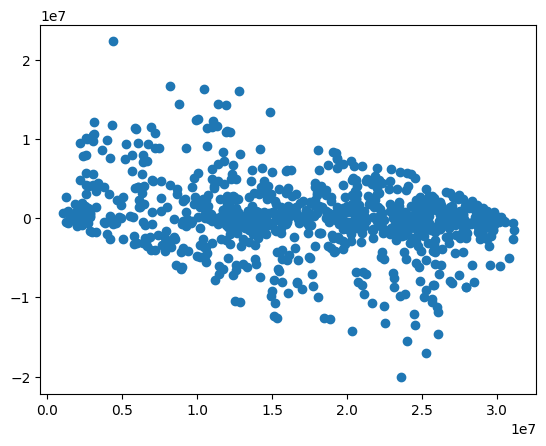

In [43]:
plt.scatter(y_test, y_pred - y_test)
plt.show()

Here, each stripe represents a leaf in the DecisionTreeRegressor. The residuals here appear relatively constant across the range of predicted values. 

# K-Fold Cross Validation

#### Hyper Parameter Tuning with Cross Validation

As we learned in class, while classification trees use measures like entropy or Gini impurity to evaluate the quality of a split, regression trees use variance (or equivalently, mean squared error) as the criterion for splitting. The key idea is to minimize the variance within each node. When constructing a decision tree for regression, at each step, the algorithm considers all possible splits on all features and selects the split that minimizes the variance of the target variable within each resulting node.

In [44]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score

# Define the cross validation scheme.
cv = KFold(n_splits=5, shuffle=True, random_state=56)


scores = cross_val_score(tree, X, y, cv=cv, scoring='neg_mean_absolute_error')
print(scores)
print(f"{'Average MAE scores without HPO: '}", -scores.mean())
print(f"{'Average MAE scores without HPO as a percentage of the mean y value: '}", f"{(-scores.mean()/np.mean(y)*100):.2f}", '%')

[-3003298.8630137  -3067330.36986301 -2833434.08219178 -2993044.42465753
 -3352185.        ]
Average MAE scores without HPO:  3049858.5479452056
Average MAE scores without HPO as a percentage of the mean y value:  18.08 %


param_grid defines the hyperparameter space that we want to search over to find the best combination of hyperparameters for our decision tree model, specifically these parameters:
'max_depth': Specifies the maximum depth of the decision tree. 
'min_samples_split': Specifies the minimum number of samples required to split an internal node. 
'max_features': Specifies the maximum number of features considered for splitting a node. It includes different options like using all features (None), the square root of the total features ('sqrt'), and the base-2 logarithm of the total features ('log2')

better_tree is a GridSearchCV object that performs a grid search over the specified hyperparameter space.

In [45]:
# Define the search space

param_grid = {
    'max_depth': [1,2,3,4,5,6,7,8,9,11,13,15],
    'min_samples_split': [2, 5, 10, 20], 
    'max_features': [None, 'sqrt', 'log2']
}

better_tree = GridSearchCV(tree, param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_error', refit=True)


better_tree.fit(X_train, y_train) 
better_scores = cross_val_score(better_tree, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')

print(f"{'Scores from CV with HPO'}", better_scores)
print(f"{'Average MAE scores with HPO: '}", -better_scores.mean())
print(f"{'Average MAE scores with HPO as a percentage of the mean y value: '}", f"{(-better_scores.mean()/np.mean(y)*100):.2f}", '%')

Scores from CV with HPO [-2612253.97021385 -2706566.80220936 -2323461.2672642  -2399904.05568053
 -2569872.63181176]
Average MAE scores with HPO:  2522411.745435939
Average MAE scores with HPO as a percentage of the mean y value:  14.95 %


In [46]:
print(f"{'The best parameters when using negative mean absolute error scoring is: '}", better_tree.best_params_)
print(f"{'The best MAE score attained was: '}", -better_tree.best_score_)

print(f"{'HPO leads to a '}", f"{(1-(-better_scores.mean()/np.mean(y))/(-scores.mean()/np.mean(y)))*100:.2f}", '%', " improvement in MAE score over the model without HPO")


The best parameters when using negative mean absolute error scoring is:  {'max_depth': 5, 'max_features': None, 'min_samples_split': 2}
The best MAE score attained was:  2501138.713554165
HPO leads to a  17.29 %  improvement in MAE score over the model without HPO


### Now let's use this new model to predict values of the test data and evaluate the model.

In [47]:
better_predictions = better_tree.predict(X_test)

my_scores = []


mse_values = ["MSE"]
mse = mean_squared_error(y_test, better_predictions)
mse_dummy = mean_squared_error(y_test, y_pred_dummy)

mse_values.append(mse)
mse_values.append(mse_dummy)

my_scores.append(mse_values)



r2_values = ["R2"]
r2 = r2_score(y_test, better_predictions)
r2_dummy = r2_score(y_test, y_pred_dummy)

r2_values.append(r2)
r2_values.append(r2_dummy)

my_scores.append(r2_values)



mae_values = ["MAE"]
mae = mean_absolute_error(y_test, better_predictions)
mae_dummy = mean_absolute_error(y_test, y_pred_dummy)

mae_values.append(mae)
mae_values.append(mae_dummy)

my_scores.append(mae_values)


print(f"{'Evaluation method':<25} {'Score':<20} {'Dummy Score':<20} {'Ratio (Score/Dummy Score)':<20}")

for item in my_scores:
    ratio = item[1]/item[2] if item[2] != 0 else 0
    print(f"{item[0]:<25} {item[1]:<20.3f} {item[2]:<20.3f} {ratio:<10.3f}")
    
    # print the ratio of the mse score over the mean value of y_test
print(f"Ratio of mae over mean value of y: {(mae)/np.mean(y):.3f}")



Evaluation method         Score                Dummy Score          Ratio (Score/Dummy Score)
MSE                       13624226764387.289   61839876045693.438   0.220     
R2                        0.779                -0.003               -283.449  
MAE                       2534957.072          6744592.742          0.376     
Ratio of mae over mean value of y: 0.150


#### Summary of Results

From the results we can see the r2 value of _________ and the mean absolute error of _________. This is a significant improvement from the baseline model which had an r2 value of _________ and a mean absolute error of _________. Compared to KNN, the model performes ___(better/worse)__ in terms of r2 and mean absolute error.